In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
train_dataset = torchvision.datasets.FashionMNIST("./dataset", download=True, train=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./dataset", download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
print(len(train_dataset), len(test_dataset))

100.0%


Extracting ./dataset\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./dataset\FashionMNIST\raw



100.0%


Extracting ./dataset\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./dataset\FashionMNIST\raw



100.0%


Extracting ./dataset\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset\FashionMNIST\raw



100.0%

Extracting ./dataset\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset\FashionMNIST\raw

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

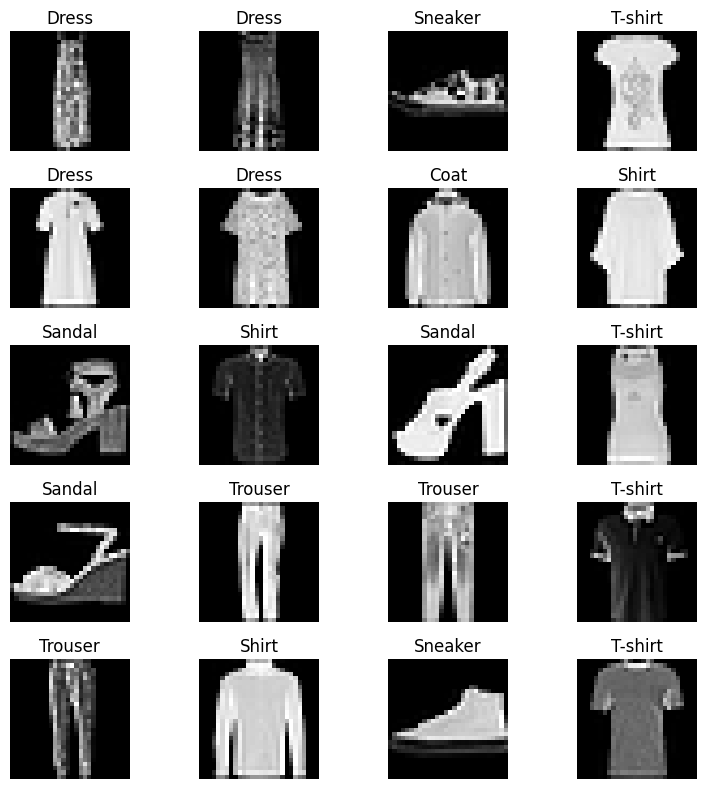

In [9]:
labels_map = {0 : 'T-shirt', 1 : "Trouser" , 2 : "Pullover", 3 : "Dress",
              4 : "Coat", 5 : "Sandal", 6 : "Shirt", 7 : "Sneaker", 8 : "Bag", 9 : "Ankle Boot"}

fig = plt.figure(figsize= (8,8))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

In [36]:
class FashionDNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
model_DNN = FashionDNN().to(device)

In [37]:
print(model_DNN)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [38]:
def train(model, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []

    prediction_list = []
    labels_list = []

    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            train = images.view(100, 1, 28, 28) # Variable 없어도 됨

            outputs= model(train)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            count += 1

            if not (count % 50):
                total = 0
                correct = 0
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
                    test = images.view(100, 1, 28, 28)
                    outputs = model(test)
                    predictions = torch.max(outputs, 1)[1].to(device)
                    prediction_list.append(predictions)
                    correct += (predictions == labels).sum()
                    total += len(labels)
                
                accuracy = correct * 100 / total
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
            
            if not (count % 500):
                print("Iteration: {}, Loss: {}, Accuracy: {}%"\
                    .format(count, loss.data, accuracy))

In [40]:
train(model_DNN, 10, 0.0003)

Iteration: 500, Loss: 0.362224817276001, Accuracy: 87.98999786376953%
Iteration: 1000, Loss: 0.3226560950279236, Accuracy: 87.87999725341797%
Iteration: 1500, Loss: 0.2724376916885376, Accuracy: 87.88999938964844%
Iteration: 2000, Loss: 0.18844865262508392, Accuracy: 87.91999816894531%
Iteration: 2500, Loss: 0.1995689421892166, Accuracy: 88.33999633789062%
Iteration: 3000, Loss: 0.17971651256084442, Accuracy: 88.12999725341797%
Iteration: 3500, Loss: 0.13257403671741486, Accuracy: 87.68999481201172%
Iteration: 4000, Loss: 0.2654087245464325, Accuracy: 88.11000061035156%
Iteration: 4500, Loss: 0.21818792819976807, Accuracy: 88.18000030517578%
Iteration: 5000, Loss: 0.1810971200466156, Accuracy: 88.32999420166016%
Iteration: 5500, Loss: 0.28494536876678467, Accuracy: 88.33999633789062%
Iteration: 6000, Loss: 0.18225006759166718, Accuracy: 87.88999938964844%


In [41]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model_CNN = FashionCNN().to(device)

In [42]:
train(model_CNN, 10, 0.005)

c:\anaconda\envs\torch_book\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.23155850172042847, Accuracy: 86.90999603271484%
Iteration: 1000, Loss: 0.32927000522613525, Accuracy: 87.2699966430664%
Iteration: 1500, Loss: 0.3520045578479767, Accuracy: 88.07999420166016%
Iteration: 2000, Loss: 0.18977424502372742, Accuracy: 89.6500015258789%
Iteration: 2500, Loss: 0.3055894672870636, Accuracy: 90.25%
Iteration: 3000, Loss: 0.22385312616825104, Accuracy: 91.0999984741211%
Iteration: 3500, Loss: 0.2039174884557724, Accuracy: 90.36000061035156%
Iteration: 4000, Loss: 0.3019624948501587, Accuracy: 89.93999481201172%
Iteration: 4500, Loss: 0.1315726488828659, Accuracy: 89.70999908447266%
Iteration: 5000, Loss: 0.13237117230892181, Accuracy: 90.43000030517578%
Iteration: 5500, Loss: 0.22278408706188202, Accuracy: 89.8499984741211%
Iteration: 6000, Loss: 0.20450279116630554, Accuracy: 90.37999725341797%
